In [1]:
import torch
import numpy as np
import os, time
import matplotlib.pyplot as plt
import matplotlib

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.transforms import v2

from tqdm import tqdm
from PIL import Image
from PIL.Image import Image as IMG
from torchinfo import summary

from sklearn.model_selection import train_test_split

from IPython.display import clear_output

import models

%matplotlib inline

In [2]:
import importlib; importlib.reload(models)

<module 'models' from 'd:\\CodingProjects\\CSC-761\\models.py'>

https://docs.python.org/3/tutorial/modules.html

In [3]:
def char_to_hex(chr):
    return hex(ord(chr))
def hex_to_char(hex):
    if type(hex) == int:
        return chr(hex)
    else:
        return chr(int(hex, 16))
def read_image_data(path):
    img = Image.open(path)
    if not img.size[0] == 128 or not img.size[1] == 128:
        img = img.resize((128,128))
    #img = img.transform(img.size, Image.AFFINE, (1,0,-10,0,1,0), fillcolor='white')
    #img.show()
    img_dat = np.array([img], dtype=np.uint8)
    img.close()
    #print(img_dat.shape)
    if(len(img_dat.shape) == 4):
        img_dat = np.average(img_dat, axis=3)
    #print(img_dat.shape)
    return img_dat

In [4]:
print(hex_to_char('0x3051'))
print(char_to_hex('け'))
read_image_data('./user_samples/04.png').shape

け
0x3051


(1, 128, 128)

In [5]:
def shift_images(images, x_shift=0, y_shift=0):
    if not len(images.size()) == 4:
        print('Input should be in dim of 4, with form BxCxHxW')
        return
    # dim 2 = y, positive down.
    # dim 3 = x, positive right.
    # Both will wrap around.
    # dim 0 would be batch, and 1 the channels
    # https://pytorch.org/docs/stable/generated/torch.roll.html
    images = torch.roll(images, shifts=(x_shift, -1 * y_shift), dims=(3, 2))
    return images

In [6]:
Output_Dest = './ETL Character DataBase/Outputs/'
Output_Dest = 'C:/Outputs/'

RAND_NOISE = 28.0 # To aid with training.
BATCH_SIZE = 100 # Memory dependant. Can go much higher when using conv2d 176 for vit
NUM_CLASSES = 0

In [7]:
# str hex to int label
classes = dict() 
# Int label to str hex
inverted_classes = dict()
# Actual image data
img_labels = []
loaded_labels = False

In [8]:
if os.path.isfile('labels_mapping.txt'):
    dat = torch.load('labels_mapping.txt')
    classes = dat['classes']
    inverted_classes = dat['inverted_classes']
    loaded_labels=True
    print('Loaded from file!')
    NUM_CLASSES = len(classes)

Loaded from file!


In [11]:
#with open('allchars.txt', 'w') as file:
#    count = 0
#    for key in inverted_classes:
#        _char = hex_to_char(inverted_classes[key])
#        if count > 70:
#            count = 0
#            file.write('\n')
#        file.write(_char)
#        count+=1
#    file.close()

In [12]:
print(len(inverted_classes))

3040


In [9]:
# Next two should match
print(classes['0x6027'], inverted_classes[960], hex_to_char(inverted_classes[960]))
print(960, '0x6027', hex_to_char('0x6027'))

960 0x6027 性
960 0x6027 性


In [10]:
load_start = time.time()
# Initial load for labels
if not loaded_labels:
    for path, dirs, files in os.walk(Output_Dest):
        for dir in dirs:
            label = len(classes)
            classes[dir] = label
            inverted_classes[label] = dir
        break
    NUM_CLASSES = len(classes)
else:
    print('Skipping initial label reading, already loaded from file.')
for elm in tqdm(classes, ncols=70):
    for path, _, files in os.walk(os.path.join(Output_Dest, elm)):
        for file in files:
            full_path = os.path.join(path, file)
            image = Image.open(full_path)
            image_data = np.array([image], dtype=np.uint8)
            image.close()
            img_labels.append((full_path, elm, image_data))
print('Finished reading in samples after '+str(time.time()-load_start)+' seconds.')

Skipping initial label reading, already loaded from file.


100%|█████████████████████████████| 3040/3040 [04:29<00:00, 11.26it/s]

Finished reading in samples after 269.9478032588959 seconds.


In [11]:
torch.save({'classes': classes,
            'inverted_classes': inverted_classes},
            'labels_mapping.txt')

In [12]:
print(len(img_labels), len(classes))

761116 3040


In [13]:
# With help from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class KanjiImageDataset(Dataset):
    def __init__(self, x_set, y_set):
        self.x = x_set
        self.y = y_set
        self.classes = classes
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        image_data = self.x[idx]
        label = self.classes[self.y[idx]]

        return image_data, label

In [14]:
X, Y, Z = zip(*img_labels)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(Z, Y, test_size=0.3, random_state=42)
print(len(x_train), len(y_train), len(x_test), len(y_test))
train_dataset = KanjiImageDataset(x_train, y_train)
test_dataset = KanjiImageDataset(x_test, y_test)
print(len(train_dataset))
print(len(test_dataset))

532781 532781 228335 228335
532781
228335


In [16]:
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda:0'
DEVICE = torch.device(DEVICE)
DEVICE

device(type='cuda', index=0)

In [17]:
# Showing that katakana is not in the samples
print(char_to_hex('ず') in classes)
print(char_to_hex('ズ') in classes)

True
False


In [18]:
BATCHES_PER_ITR = 1

In [19]:
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
BATCHES_PER_ITR = len(train_data_loader)
BATCHES_PER_ITR

5328

In [20]:
transforms = v2.Compose([
    v2.RandomAffine(degrees=0, scale=(0.6,1.6), interpolation=v2.InterpolationMode.NEAREST, fill=255),
    v2.RandomAffine(degrees=(-10,10), translate=(0.25,0.25), interpolation=v2.InterpolationMode.NEAREST, fill=255),
    v2.RandomPerspective(distortion_scale=0.35, p=0.15, interpolation=v2.InterpolationMode.NEAREST, fill=255)
])

In [21]:
#matplotlib.font_manager.get_font_names()

In [22]:
train_features, train_labels = next(iter(train_data_loader))

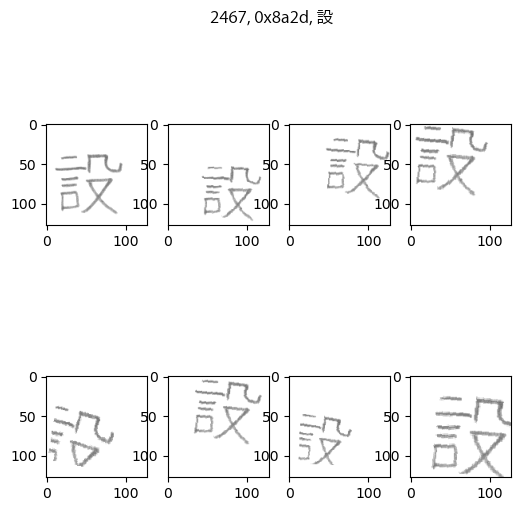

2467 0x8a2d 設


In [23]:
img = Image.fromarray(train_features[0].squeeze().numpy(), mode="L")
label = train_labels[0].item()
fig = plt.figure(figsize=(6,6))
fig.suptitle(f'{label}, {inverted_classes[label]}, {hex_to_char(inverted_classes[label])}', family = 'Kozuka Gothic Pro')
ax = fig.add_subplot(2,4,1)
plt.imshow(img, cmap='gray', vmin=0.0, vmax=255.0)
for i in range(2,9):
    img = Image.fromarray(transforms(train_features)[0].squeeze().numpy(), mode="L")
    ax = fig.add_subplot(2,4,i)
    plt.imshow(img, cmap='gray', vmin=0.0, vmax=255.0)
    #ax.set_axis_off()
#plt.savefig('./documentation/Augmentation_Example.png')
plt.show()
print(label, inverted_classes[label], hex_to_char(inverted_classes[label]))

In [24]:
import importlib; importlib.reload(models)

<module 'models' from 'd:\\CodingProjects\\CSC-761\\models.py'>

In [78]:
model, optimizer, scheduler = models.construct_resnet_18(NUM_CLASSES, BATCHES_PER_ITR)
model = model.to(DEVICE)
print(model)
print(summary(model, input_size=(BATCH_SIZE,1,128,128)))

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
model, optimizer, scheduler = models.construct_vit_v4_2(NUM_CLASSES, BATCHES_PER_ITR)
model = model.to(DEVICE)

#plt.imshow(vit_net.get_positional_embeddings(65, 128), cmap="hot", interpolation="nearest")
#plt.show()

#print(vit_net(torch.rand(BATCH_SIZE, 1, 128, 128).to(DEVICE)).size())
#print(vit_net)
print(summary(model, input_size=(BATCH_SIZE, 1, 128, 128)))

d:\CodingProjects\CSC-761\models.py:209: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(self.get_positional_embeddings(self.num_patches + 1, self.hidden_dim)))


Layer (type:depth-idx)                        Output Shape              Param #
VITNet_v4                                     [100, 3040]               7,138,560
├─Sequential: 1-1                             [100, 64, 768]            --
│    └─Linear: 2-1                            [100, 64, 3072]           789,504
│    └─ReLU: 2-2                              [100, 64, 3072]           --
│    └─Linear: 2-3                            [100, 64, 768]            2,360,064
│    └─BatchNorm1d: 2-4                       [100, 64, 768]            128
│    └─ReLU: 2-5                              [100, 64, 768]            --
│    └─Dropout: 2-6                           [100, 64, 768]            --
├─TransformerEncoder: 1-2                     [100, 65, 768]            --
│    └─ModuleList: 2-7                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [100, 65, 768]            7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [100, 65, 768]        

c:\Users\nickb\anaconda3\envs\csc761projectcuda\Lib\site-packages\torch\nn\modules\transformer.py:685: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._transformer_encoder_layer_fwd(


In [79]:
torch.cuda.empty_cache()

In [80]:
history_x = []
history_y = []

In [81]:
# Loss Function
criterion = nn.CrossEntropyLoss()

https://discuss.pytorch.org/t/how-to-save-and-load-lr-scheduler-stats-in-pytorch/20208

In [98]:
BEST_CHKPNT = '_res_18_9_70.96%_0.0%'+'.pth'
RESUME = True
SAVEPATH = './checkpoints/'
last_epoch_num = 0

In [99]:
def load_from_checkpoint(_full_path, _model, _optim, _sched):
    global last_epoch_num
    global history_x, history_y
    if os.path.isfile(_full_path):
        checkpoint = torch.load(_full_path)
        _model.load_state_dict(checkpoint['model'])
        _model.to(DEVICE)
        _optim.load_state_dict(checkpoint['optimizer'])
        _sched.load_state_dict(checkpoint['scheduler'])
        last_epoch_num = checkpoint['epoch']
        his = checkpoint['history']
        history_x, history_y = his
        print('Successfully loaded all params!')
        print(f'Epoch: {last_epoch_num}')
    else:
        print('File not found or some other error.')

In [100]:
if RESUME:
    _full_path = os.path.join(SAVEPATH, BEST_CHKPNT)
    load_from_checkpoint(_full_path, model, optimizer, scheduler)
else:
    print('Did not resume.')        

Successfully loaded all params!
Epoch: 9


In [101]:
# from: https://discuss.pytorch.org/t/obtain-the-attention-weights-within-transformer-class/165456
#attn_weights = vit_net.encoder_layer.state_dict()['self_attn.in_proj_weight']
#attn_weights[0]

In [102]:
def save_checkpoint(_path, _model, _opti, _scheduler, _history, _epoch):
    state = {'model': _model.state_dict(),
             'optimizer': _opti.state_dict(),
             'scheduler': _scheduler.state_dict(),
             'history': _history,
             'epoch': _epoch}
    torch.save(state, _path)

In [103]:
last_epoch_num

9

In [104]:
#for param_ in vit_optimizer.param_groups:
#    param_['lr'] = 0.001

In [105]:
#vit_optimizer.param_groups

In [106]:
print(f'[{scheduler.get_last_lr()[0]:.5f}]')

[0.05000]


In [107]:
# Read in the user samples
EVAL_PATH = './user_samples/eval/'
eval_images = []
for elm in tqdm(classes, ncols=70):
    for path, _, files in os.walk(os.path.join(EVAL_PATH, elm)):
        for file in files:
            full_path = os.path.join(path, file)
            image_data = read_image_data(full_path)
            eval_images.append((full_path, elm, image_data))
print('Finished reading in all evaluation samples.')
_, eval_y, eval_z = zip(*eval_images)
eval_dataset = KanjiImageDataset(eval_z, eval_y)
print(len(eval_dataset))
eval_data_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(eval_data_loader))

100%|██████████████████████████| 3040/3040 [00:00<00:00, 10780.21it/s]

Finished reading in all evaluation samples.
65
1


In [108]:
def preprocess_minibatch(mini_batch, transform = False, noise=0.0):
    inputs, labels = mini_batch
    inputs = inputs.to(torch.float32)
    # First, transform the training set randomly is requested.
    if transform:
        inputs = transforms(inputs)
    # Next, add random noise to the image if requested to help with training, keep clamped within [0, 255].
    if noise > 0.0:
        inputs = torch.clamp(inputs + torch.randn_like(inputs) * RAND_NOISE, 0.0, 255.0)
    # Invert and normazlize from [0,1]
    inputs = 1.0 - (inputs / 255.0)
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    return inputs, labels

In [109]:
def evaluate_model(_model, _data_loader, transform=False, top_n=5):
    correct = 0
    top_five_correct = 0
    total = 0
    lsm = nn.LogSoftmax(dim=1)
    mrr = []
    class_correct = {classlabel: 0 for classlabel in inverted_classes}
    class_total = {classlabel: 0 for classlabel in inverted_classes}
    class_top_five_correct = {classlabel: 0 for classlabel in inverted_classes}
    with torch.no_grad():
        _model.train(False)
        for mini_batch in tqdm(_data_loader, desc='Evaluation:', ncols=80):
            inputs, labels = preprocess_minibatch(mini_batch, transform=transform)

            outputs = _model(inputs)
            _, preds = torch.max(lsm(outputs.data), dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            top_five_correct += (preds == labels).sum().item()

            for label, pred in zip(labels, preds):
                label = label.item()
                pred = pred.item()
                if label == pred:
                    class_correct[label] += 1
                    class_top_five_correct[label] += 1
                class_total[label] += 1

            mrr.append((preds == labels).sum().item())
            for i in range(top_n-1):
                # Set the top predicted logit for each sample to zero, this will be the lowest going in softmax.
                for j in range(inputs.size()[0]):
                    outputs[j][preds[j]] = 0.0
                label, preds = torch.max(lsm(outputs.data), dim=1)
                top_five_correct += (preds == labels).sum().item()
                for label, pred in zip(labels, preds):
                    label = label.item()
                    pred = pred.item()
                    if label == pred:
                        class_top_five_correct[label] += 1
                mrr.append((preds == labels).sum().item() / (i+1))
        print(f'{(correct/total)*100:.3f}%', f'| Top {top_n} Chance:',
              f'{(top_five_correct/total)*100:.3f}%', 'MRR:', f'{np.sum(mrr)/total:.4f}')
    return (class_correct, class_total, class_top_five_correct)

In [110]:
def train_model(_model, optimizer, scheduler, chk_prfk, num_epochs = 5,
                _offset = 0, _scheduler_update_on_epoch = True):
    global last_epoch_num
    running_loss = 0.0
    lsm = nn.LogSoftmax(dim=1)

    for epoch in range(num_epochs):
        
        epoch_start = time.time()
        _model.train(True)
        running_loss = 0.0
        # Training loop
        correct,total,train_percent = 0,0,0
        for mini_batch in tqdm(train_data_loader, desc=f'Epoch {last_epoch_num+1}', ncols=80):
            #clear_output(wait=True)
            inputs, labels = preprocess_minibatch(mini_batch)
            
            # Zero grad, predict and run loss
            optimizer.zero_grad()
            outputs = _model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if not _scheduler_update_on_epoch:
                scheduler.step()

            # Collect training metrics
            running_loss += loss.item()
            _, preds = torch.max(lsm(outputs.data), dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        train_percent = (correct/total)*100
        epoch_time = time.time() - epoch_start
        last_epoch_num = _offset + epoch + 1
        print('Epoch', f'{last_epoch_num}:', f'Loss: {(running_loss / len(train_data_loader)):.2f}',
              '| Accuracy:', f'{(correct/total)*100:.3f}%',
              'Time Taken:', f'{int(epoch_time/60)}m {(epoch_time%60):.2f}s',
              '| LR:', f'[{scheduler.get_last_lr()[0]:.5f}]')
        running_loss = 0.0
        if _scheduler_update_on_epoch:
            scheduler.step()

        # Validation Loop.
        correct = 0
        total = 0
        with torch.no_grad():
            _model.train(False)
            for mini_batch in tqdm(test_data_loader, desc='- Validation', ncols=80):
                inputs, labels = preprocess_minibatch(mini_batch)

                outputs = _model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(lsm(outputs.data), dim=1)

                total += labels.size(0)
                correct += (preds == labels).sum().item()
            validation_percent = (correct/total)*100
            
        # Finally Eval to check for overfitting on user created.
        eval_total, eval_correct = 0, 0
        with torch.no_grad():
            _model.train(False)
            for mini_batch in eval_data_loader:
                inputs, labels = preprocess_minibatch(mini_batch)

                outputs = _model(inputs)
                eval_loss = criterion(outputs, labels)
                _, preds = torch.max(lsm(outputs.data), dim=1)

                eval_total += labels.size(0)
                eval_correct += (preds == labels).sum().item()
            eval_percent = (eval_correct/eval_total)*100
        history_x.append([len(history_x)+1, len(history_x)+1, len(history_x)+1])
        history_y.append([train_percent, validation_percent, eval_percent])
        total_time = time.time()-epoch_start
        print('-', 'Validation: '+f'{validation_percent:.3f}%',
              'Training: '+f'{train_percent:.3f}%',
              'Evaluation: '+f'{eval_percent:.3f}%',
              f'Val Loss: {loss:.2f}',
              f'Eval Loss: {eval_loss:.2f}',
              'Total Time Taken:', f'{int(total_time/60)}m {(total_time%60):.2f}s')
        save_path = SAVEPATH+'_'+chk_prfk+'_'+str(last_epoch_num)+f'_{validation_percent:.2f}%_{eval_percent:.1f}%'+'.pth'
        save_checkpoint(save_path, _model, optimizer, scheduler, (history_x, history_y), last_epoch_num)
    print('Done training.')

In [96]:
train_model(model, optimizer, scheduler, 'res_18', num_epochs = 2,
            _offset = last_epoch_num, _scheduler_update_on_epoch=False)

Epoch 9: 100%|██████████████████████████████| 5328/5328 [03:22<00:00, 26.35it/s]


Epoch 9: Loss: 0.71 | Accuracy: 81.837% Time Taken: 3m 22.17s | LR: [0.05000]


- Validation: 100%|█████████████████████████| 2284/2284 [00:40<00:00, 55.90it/s]


- Validation: 70.956% Training: 81.837% Evaluation: 0.000% Val Loss: 1.03 Eval Loss: 14.86 Total Time Taken: 4m 3.10s


Epoch 10: 100%|█████████████████████████████| 5328/5328 [03:40<00:00, 24.15it/s]


Epoch 10: Loss: 0.64 | Accuracy: 83.437% Time Taken: 3m 40.61s | LR: [0.05000]


- Validation: 100%|█████████████████████████| 2284/2284 [00:39<00:00, 57.18it/s]

- Validation: 70.830% Training: 83.437% Evaluation: 0.000% Val Loss: 1.27 Eval Loss: 16.18 Total Time Taken: 4m 20.57s
Done training.


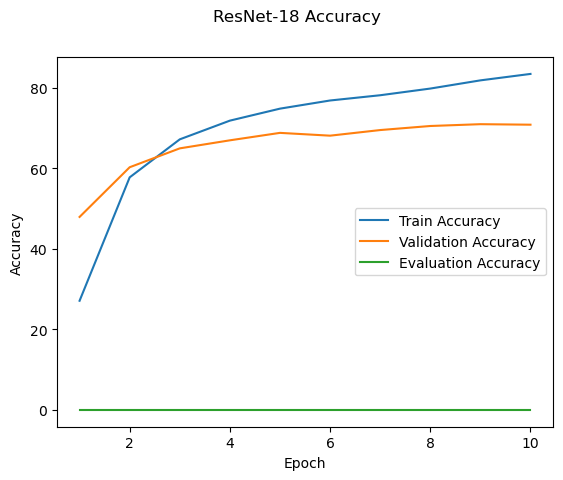

In [97]:
fig, ax = plt.subplots()
fig.suptitle(f'ResNet-18 Accuracy')
ax.plot(history_x, history_y)
ax.legend(['Train Accuracy', 'Validation Accuracy', 'Evaluation Accuracy'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#plt.savefig('VitNet_V4-2.png', bbox_inches='tight')
plt.show()

In [44]:
for path, folders, files in os.walk(SAVEPATH):
    break
    for file in files:
        if '_v4_1_' in file:
            _chckpnt = os.path.join(path, file)
            print(_chckpnt)
            load_from_checkpoint(_chckpnt)
            _,_,_ = evaluate_model(vit_net, eval_data_loader, transform=False, top_n=5)
    break

In [112]:
correct_counts, total_counts, correct_topn_counts = evaluate_model(model, eval_data_loader, transform=False, top_n=5)

Evaluation:: 100%|████████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]

0.000% | Top 5 Chance: 1.538% MRR: 0.0038


In [113]:
class_accs = []
show_best = False
for label in total_counts:
    if total_counts[label] > 0:
        class_accs.append((100 * (correct_counts[label] / total_counts[label]),
                           correct_counts[label], total_counts[label], label,
                           100 * (correct_topn_counts[label] / total_counts[label])))
class_accs = sorted(class_accs, reverse=show_best)
print('Percent Correct Total ID Top5')
for itr in range(min(40, len(class_accs))):
    _a, _b, _c, _, _d = class_accs[itr]
    print(f'({_a:.1f}, {_b:4d} / {_c:04d}, {_d:.1f})', hex_to_char(inverted_classes[class_accs[itr][3]]))

Percent Correct Total ID Top5
(0.0,    0 / 0001, 0.0) う
(0.0,    0 / 0001, 0.0) 保
(0.0,    0 / 0001, 0.0) 八
(0.0,    0 / 0001, 0.0) 団
(0.0,    0 / 0001, 0.0) 圭
(0.0,    0 / 0001, 0.0) 妙
(0.0,    0 / 0001, 0.0) 桁
(0.0,    0 / 0001, 0.0) 磐
(0.0,    0 / 0002, 0.0) ぱ
(0.0,    0 / 0002, 0.0) 九
(0.0,    0 / 0002, 0.0) 佑
(0.0,    0 / 0002, 0.0) 侭
(0.0,    0 / 0002, 0.0) 努
(0.0,    0 / 0002, 0.0) 南
(0.0,    0 / 0002, 0.0) 及
(0.0,    0 / 0002, 0.0) 呉
(0.0,    0 / 0002, 0.0) 因
(0.0,    0 / 0002, 0.0) 域
(0.0,    0 / 0002, 0.0) 妥
(0.0,    0 / 0002, 0.0) 容
(0.0,    0 / 0002, 50.0) 怒
(0.0,    0 / 0002, 0.0) 搭
(0.0,    0 / 0002, 0.0) 武
(0.0,    0 / 0002, 0.0) 源
(0.0,    0 / 0002, 0.0) 炉
(0.0,    0 / 0002, 0.0) 皿
(0.0,    0 / 0002, 0.0) 賂
(0.0,    0 / 0002, 0.0) 述
(0.0,    0 / 0002, 0.0) 隣
(0.0,    0 / 0002, 0.0) 題
(0.0,    0 / 0002, 0.0) 首
(0.0,    0 / 0002, 0.0) 鯨
(0.0,    0 / 0003, 0.0) と
(0.0,    0 / 0003, 0.0) 捌
(0.0,    0 / 0003, 0.0) 日


In [62]:
def model_predict(_model, imgs, labels, noise = 0.0, top_n=10, transform = False):
    lsm = nn.LogSoftmax(dim=1)

    # some checks 
    if(not (type(imgs) == torch.Tensor) or not (type(labels) == torch.Tensor)):
        return
    
    # Add dims as needed
    if(len(imgs.size()) == 3):
        imgs = imgs[None, :, :, :]

    # We actually only predict the first record
    img = Image.fromarray(imgs[0].squeeze().numpy(), mode="L")

    if noise > 0.0:
        img_dat = imgs[0].squeeze()
        img_dat = img_dat.to(torch.float32)
        img_dat = torch.clamp(img_dat + torch.randn_like(img_dat) * noise, 0.0, 255.0)
        img = Image.fromarray(img_dat.to(torch.uint8).numpy(), mode="L")
    label = labels[0].item()
    plt.imshow(img, cmap='gray')
    plt.show()
    print(label, inverted_classes[label], hex_to_char(inverted_classes[label]))

    possible_choices = []
    choices_weights = []
    with torch.no_grad():
        _model.train(False)

        inputs, labels = preprocess_minibatch((imgs, labels), transform, noise)
        
        inputs = imgs.to(torch.float32)
        inputs = torch.clamp(inputs + torch.randn_like(inputs) * noise, 0.0, 255.0)
        inputs = 1.0 - (inputs / 255.0)

        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = _model(inputs)
        
        for _ in range(top_n):
            weights, preds = torch.max(lsm(outputs.data), dim=1)
            choice = preds[0].item()
            possible_choices.append(choice)
            outputs[0][choice] = 0.0
            choices_weights.append(weights[0])
        for index, elm in enumerate(zip(possible_choices, choices_weights)):
            choice, weight = elm
            print(f'Rank: {(index+1):2d} {choice:05d} {hex_to_char(inverted_classes[choice])} {choice == labels[0].item()} {weight}')
            #print('Rank: ', index+1, choice, hex_to_char(inverted_classes[choice]), choice == labels[0].item(), weight)

In [63]:
def check_patches(images, noise, do_save = False, transform=False):
    fig = plt.figure(figsize=(3, 3))
    fig.add_subplot(1,1,1)
    plt.imshow(Image.fromarray(images[0].squeeze().numpy(), mode="L"), cmap='gray')
    print(images.size())

    if transform:
        images = transforms(images)

    # Add optional random noise to the image, kept clamped within [0, 255]
    images = images.to(torch.float32)
    images = torch.clamp(images + torch.randn_like(images) * noise, 0.0, 255.0)
    images = 1.0 - (images / 255.0)

    patches = model.patchify(images, images.size()[0])

    patches = patches.reshape(images.size()[0],64,16,16)
    patch = patches[0] * 255.0

    fig = plt.figure(figsize=(3, 3))
    fig.add_subplot(1,1,1)
    plt.imshow(Image.fromarray(images[0].squeeze().numpy()*255.0, mode="F"), cmap='gray', vmin=0.0, vmax=255.0)

    fig = plt.figure(figsize=(5, 5), layout = 'tight')
    for itr, pat in enumerate(patch):
        fig.add_subplot(8,8,itr+1)
        patch_img = Image.fromarray(pat.squeeze().numpy(), mode="F")
        if do_save:
            save_img = patch_img.convert(mode='L')
            save_img.save(f'./documentation/patches/{itr}.png')
        plt.imshow(patch_img, cmap='gray', vmin=0.0, vmax=255.0)
        plt.axis('off') 

In [71]:
sample_data_, sample_label_ = next(iter(eval_data_loader))

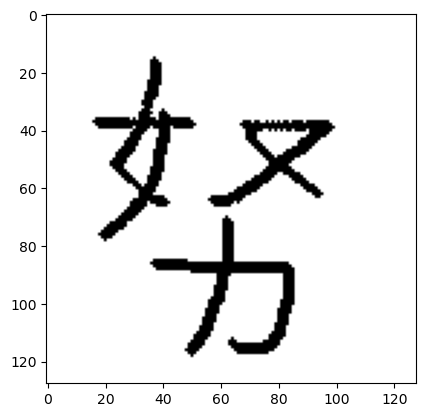

352 0x52aa 努
Rank:  1 00352 努 True -7.022242546081543
Rank:  2 02001 答 False -7.05429220199585
Rank:  3 00505 啓 False -7.065649032592773
Rank:  4 00735 容 False -7.6507039070129395
Rank:  5 01998 筏 False -7.778780937194824
Rank:  6 01247 智 False -7.832596778869629
Rank:  7 01788 留 False -7.842210292816162
Rank:  8 01669 照 False -7.8598713874816895
Rank:  9 01821 発 False -7.882016181945801
Rank: 10 01961 究 False -7.905028343200684
Rank: 11 01916 禁 False -7.916675090789795
Rank: 12 01986 笈 False -7.955872535705566
Rank: 13 02928 飛 False -7.976400375366211
Rank: 14 01991 符 False -7.981154441833496
Rank: 15 01661 無 False -7.990220069885254
torch.Size([65, 1, 128, 128])


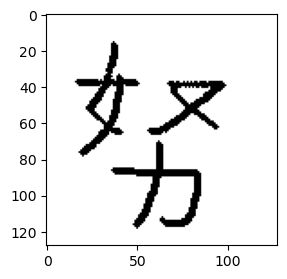

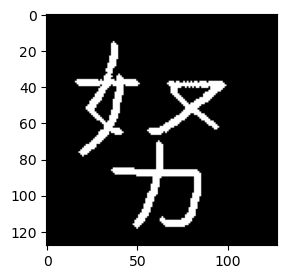

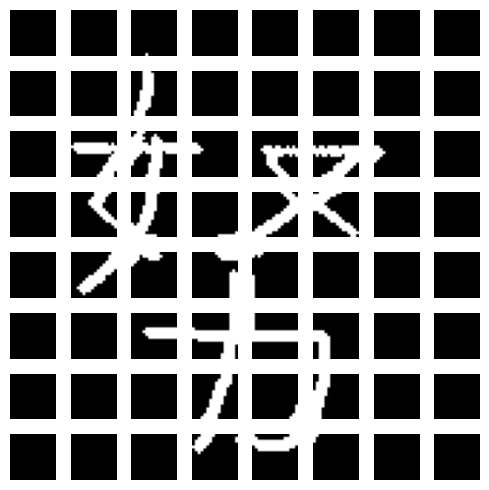

In [72]:
model_predict(model, sample_data_, sample_label_, 0.0, 15)
check_patches(sample_data_, 0.0)

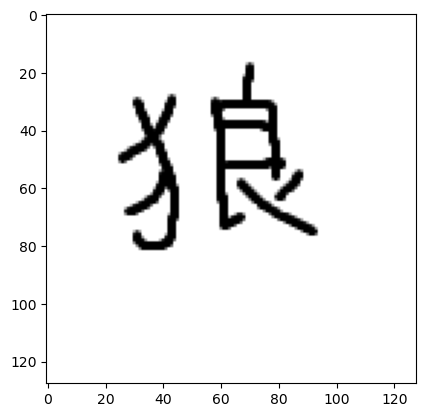

1720 0x72fc 狼
Rank:  1 00938 徳 False -7.028426170349121
Rank:  2 02435 複 False -7.038039684295654
Rank:  3 01720 狼 True -7.0459723472595215
Rank:  4 02447 視 False -7.047368049621582
Rank:  5 00935 復 False -7.364817142486572
Rank:  6 01952 穂 False -7.417016983032227
Rank:  7 01211 旗 False -7.483440399169922
Rank:  8 01729 猿 False -7.705781936645508
Rank:  9 01608 漁 False -7.715387344360352
Rank: 10 00908 張 False -7.7165846824646
Rank: 11 01348 根 False -7.826406478881836
Rank: 12 01956 穏 False -7.834957122802734
Rank: 13 02084 絶 False -7.857043266296387
Rank: 14 00198 便 False -7.867589950561523
Rank: 15 01568 混 False -7.898009777069092
Rank: 16 01557 液 False -7.913294792175293
Rank: 17 02545 貌 False -7.914274215698242
Rank: 18 00923 彼 False -7.919699668884277
Rank: 19 02446 規 False -7.924351215362549
Rank: 20 01135 提 False -7.948416709899902
torch.Size([1, 1, 128, 128])


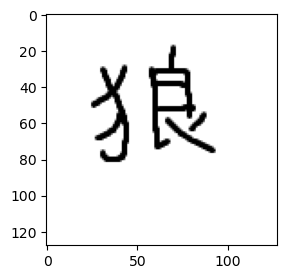

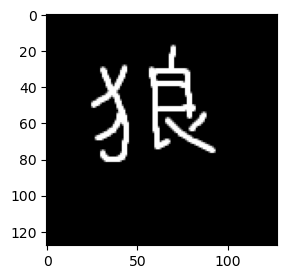

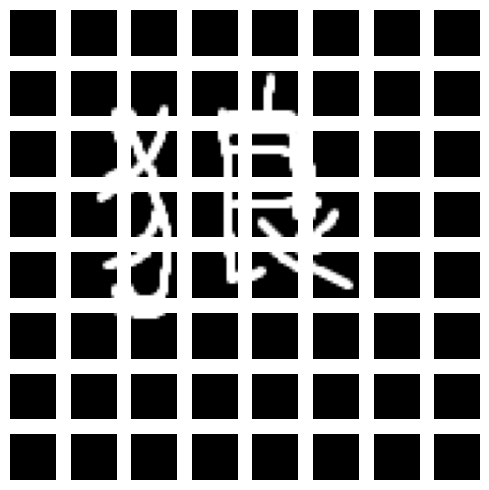

In [66]:
user_sample_img = torch.tensor([read_image_data('./user_samples/05.png')], dtype=torch.uint8)
model_predict(model,
              user_sample_img,
              torch.tensor([classes[char_to_hex('狼')]]),
              noise=0.0,
              top_n=20
              )
check_patches(user_sample_img, 0.0)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.device_count()

1

In [ ]:
torch.cuda.current_device()

0

In [ ]:
print(torch.version.cuda)

11.8


In [ ]:
mlem = torch.rand(2,4,2)#[:, 0]
mlem_dropout = nn.Dropout(p=0.50)
mlem

tensor([[[0.8140, 0.4868],
         [0.9601, 0.7754],
         [0.8962, 0.0491],
         [0.6512, 0.6928]],

        [[0.3894, 0.0096],
         [0.0942, 0.8230],
         [0.7917, 0.1312],
         [0.9673, 0.3296]]])

In [ ]:
mlem_dropout(mlem)

tensor([[[1.6281, 0.9735],
         [1.9203, 1.5508],
         [1.7924, 0.0981],
         [0.0000, 1.3857]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [1.5834, 0.0000],
         [0.0000, 0.0000]]])

From: https://stackoverflow.com/questions/61647207/how-to-extract-patches-from-an-image-in-pytorch

In [ ]:
patch_size = 8

In [ ]:
ttt = torch.rand(BATCH_SIZE,1,16,16)
print(ttt.size())
print(ttt[0][0])

torch.Size([100, 1, 16, 16])
tensor([[0.8363, 0.0416, 0.7600, 0.3908, 0.8783, 0.6077, 0.0190, 0.4757, 0.0232,
         0.0208, 0.2932, 0.5074, 0.6111, 0.1888, 0.8078, 0.2384],
        [0.8329, 0.5896, 0.6700, 0.6530, 0.3408, 0.6287, 0.7095, 0.1257, 0.0706,
         0.0718, 0.0916, 0.7187, 0.3391, 0.1856, 0.2303, 0.5290],
        [0.6380, 0.5747, 0.3333, 0.9254, 0.6373, 0.1022, 0.9620, 0.2880, 0.1594,
         0.8649, 0.1631, 0.3496, 0.2890, 0.5945, 0.7806, 0.1145],
        [0.3366, 0.7077, 0.9776, 0.9259, 0.2153, 0.3180, 0.4723, 0.8698, 0.2558,
         0.8450, 0.8330, 0.6345, 0.1536, 0.4638, 0.2672, 0.8064],
        [0.9431, 0.7713, 0.2999, 0.6828, 0.1916, 0.2540, 0.4744, 0.1404, 0.7984,
         0.5032, 0.4763, 0.9725, 0.9274, 0.3202, 0.8815, 0.1232],
        [0.7716, 0.6885, 0.1662, 0.7855, 0.0197, 0.4603, 0.2746, 0.2072, 0.0773,
         0.8922, 0.3690, 0.4870, 0.6706, 0.4452, 0.4022, 0.3822],
        [0.7958, 0.9597, 0.4899, 0.9073, 0.3902, 0.9889, 0.1014, 0.3347, 0.7229,
        

In [ ]:
#print(ttt.unfold(2,patch_size,patch_size).unfold(3,patch_size,patch_size))

In [ ]:
ttt_f = torch.squeeze(ttt.unfold(2, patch_size, patch_size).unfold(3 ,patch_size, patch_size).reshape(BATCH_SIZE,
                                                                                                      1, -1, patch_size, patch_size).flatten(3), 1)
print(ttt_f.size())
ttt_f[0][0][0]

torch.Size([100, 4, 64])


tensor(0.8363)

In [ ]:
aaa = torch.rand(8,8)
aaa

tensor([[0.8236, 0.2439, 0.0203, 0.6826, 0.1814, 0.4239, 0.8783, 0.6773],
        [0.8961, 0.0425, 0.1593, 0.1384, 0.4270, 0.4672, 0.6935, 0.1733],
        [0.3240, 0.9774, 0.3538, 0.7762, 0.4575, 0.2683, 0.8972, 0.5107],
        [0.8411, 0.8967, 0.1361, 0.7925, 0.0923, 0.1306, 0.5502, 0.6006],
        [0.6099, 0.5807, 0.1575, 0.1454, 0.4509, 0.4824, 0.5501, 0.4662],
        [0.1045, 0.7746, 0.7667, 0.1459, 0.0263, 0.8011, 0.2882, 0.9259],
        [0.7717, 0.2918, 0.3996, 0.8189, 0.5880, 0.6721, 0.3878, 0.5005],
        [0.5496, 0.0186, 0.0950, 0.8591, 0.6869, 0.1948, 0.9392, 0.8840]])

In [ ]:
aaa.unfold(0, 4, 4)

tensor([[[0.8236, 0.8961, 0.3240, 0.8411],
         [0.2439, 0.0425, 0.9774, 0.8967],
         [0.0203, 0.1593, 0.3538, 0.1361],
         [0.6826, 0.1384, 0.7762, 0.7925],
         [0.1814, 0.4270, 0.4575, 0.0923],
         [0.4239, 0.4672, 0.2683, 0.1306],
         [0.8783, 0.6935, 0.8972, 0.5502],
         [0.6773, 0.1733, 0.5107, 0.6006]],

        [[0.6099, 0.1045, 0.7717, 0.5496],
         [0.5807, 0.7746, 0.2918, 0.0186],
         [0.1575, 0.7667, 0.3996, 0.0950],
         [0.1454, 0.1459, 0.8189, 0.8591],
         [0.4509, 0.0263, 0.5880, 0.6869],
         [0.4824, 0.8011, 0.6721, 0.1948],
         [0.5501, 0.2882, 0.3878, 0.9392],
         [0.4662, 0.9259, 0.5005, 0.8840]]])

In [ ]:
aaa.unfold(0, 4, 4).unfold(1, 4, 4)

tensor([[[[0.8236, 0.2439, 0.0203, 0.6826],
          [0.8961, 0.0425, 0.1593, 0.1384],
          [0.3240, 0.9774, 0.3538, 0.7762],
          [0.8411, 0.8967, 0.1361, 0.7925]],

         [[0.1814, 0.4239, 0.8783, 0.6773],
          [0.4270, 0.4672, 0.6935, 0.1733],
          [0.4575, 0.2683, 0.8972, 0.5107],
          [0.0923, 0.1306, 0.5502, 0.6006]]],


        [[[0.6099, 0.5807, 0.1575, 0.1454],
          [0.1045, 0.7746, 0.7667, 0.1459],
          [0.7717, 0.2918, 0.3996, 0.8189],
          [0.5496, 0.0186, 0.0950, 0.8591]],

         [[0.4509, 0.4824, 0.5501, 0.4662],
          [0.0263, 0.8011, 0.2882, 0.9259],
          [0.5880, 0.6721, 0.3878, 0.5005],
          [0.6869, 0.1948, 0.9392, 0.8840]]]])

In [ ]:
aaa.unfold(0, 4, 4).unfold(1, 4, 4).reshape(-1, 4, 4)

tensor([[[0.8236, 0.2439, 0.0203, 0.6826],
         [0.8961, 0.0425, 0.1593, 0.1384],
         [0.3240, 0.9774, 0.3538, 0.7762],
         [0.8411, 0.8967, 0.1361, 0.7925]],

        [[0.1814, 0.4239, 0.8783, 0.6773],
         [0.4270, 0.4672, 0.6935, 0.1733],
         [0.4575, 0.2683, 0.8972, 0.5107],
         [0.0923, 0.1306, 0.5502, 0.6006]],

        [[0.6099, 0.5807, 0.1575, 0.1454],
         [0.1045, 0.7746, 0.7667, 0.1459],
         [0.7717, 0.2918, 0.3996, 0.8189],
         [0.5496, 0.0186, 0.0950, 0.8591]],

        [[0.4509, 0.4824, 0.5501, 0.4662],
         [0.0263, 0.8011, 0.2882, 0.9259],
         [0.5880, 0.6721, 0.3878, 0.5005],
         [0.6869, 0.1948, 0.9392, 0.8840]]])